# Demo - Probabilistic Fourier (single sample)

This file provides an demo of the probabilistic Fourier framework as outline in "Bayesian spectrum estimation of unevenly sampled data" - Qi et al.

$$ {\bf{s}}_t = {\bf{s}}_{t-1} + {\bf{w}}_t $$
$$ {\bf{y}}_t = C^\top {\bf{s}}_t + {\bf{v}}_t $$

The single sample approach is used to prevent error relating to the positive definiteness of the covariance matrices.

## Load packages and functions

In [1]:
using ForneyLab       # based on last official release
using LinearAlgebra
using Plots
using PyPlot
using ProgressMeter
using Compat
using WAV
using Base64
using FileIO
using HDF5
using FLAC
using DSP
using FFTW

include("../functions/auxiliary/buffer.jl")
include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/auxiliary/fourier.jl")
;

## Settings

In [2]:
# data loading
sound_file = "../data/obama.wav"   # specify sound location
fs_desired = 8000                  # specify desired sampling frequency

# input buffer parameters
step_size = 1                      # specify step size of buffer
buffer_size = 32                   # specify size of buffer

# probabilistic fourier parameters 
σ_observation = 0.01                # specify observation noise std
σ_process = 1e2                    # specify process noise std
freq_bins = 15
freq = collect(fs_desired/(2*(freq_bins+1)):fs_desired/(2*(freq_bins+1)):(fs_desired/2-fs_desired/(2*(freq_bins+1))))
;

## Load data

In [3]:
# load and process speech signal
x_time, fs_time = wavread(sound_file, format="native")
fs_time = Int(fs_time)
x_time = x_time[24*fs_time+1:27*fs_time]
x_time = resample(x_time, fs_desired/fs_time)
x_time = 100*x_time/var(x_time)

# specify time axis
t = collect((1:length(x_time))/fs_desired)

# create audioplayer
audioplayers(x_time, fs=fs_desired)
;

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQBGmbQ8fipHPduSKj2LnQQ9f8icPAh4ETy2sAu8jBPOvBMsCr3VU/G8OWa0vF/NHbxh1zu79oG+O9VYmTsgK+g7rZBtPBCmejyUuII8bnWHPCwYjTzxfoI8dkDZO3msObw7Aee8Yc4FvaN0Gr3fdf68o+ePvHdxlLsfipA8w+YqPYEabT3DYYQ9fx5xPc3PRj1tBSg9x5wNPV9t3Dx8pMg8cDeZPM+UqDv3YCm8XHSKvFcleLwyCWu8KjkIvDoVFDt8h3Q5IPqhOzkMszzvExU9gI02PVIbIz1vsd48at6nO5hQrbxJySK9IzVavSOLiL0eHpO90gR3vYnNNr2XSMu8Yn+Ju25iRjy/scA8bUaJPJ8u/TsmzL+7IH5vvKUr+rxxzSG9nrMYvdHs3rwFdIS8rFAyvGFTdbxL3y68UcZhutQcZzvA/W48W9CIPK62tjw/ja88Lmx5PDwJcjsN1kq8To4NvalBQr3Jdk698i88vRnh/rxZ1kW8fGvlO5wfyDw9QCI9O0A/PcMNMD118ew8eGsfPDGViLo1YS28CNi8vMJEH73MCVO9eq9tvSJTab0zEEi9J17cvAIvO7xMewA69rYFPMNogTxX5aU8SeKfPHd7lTy377g8btrsPAHc/jxu9sU8vgz4O8BhK7w8ury8lB/JvG2AsLwCwpO8B8cevK2GaDulRqI8rswfPfpgST1iYUU97UkdPYjrpzxbVoC7v3vSvBj9IL0Xyj69PQRTvT9OXr14u2u9WDFsvXdCWb3kLjK9tHfevOsYiLxDcdK7GZeDu0DmJDt1j7Q7CZBjO+QxAbvjvA+87tbJvF3M9ry8cw+9fzUQvUmIpbx0V9g72PkUPfHAWT1Hnno94Y1vPZsCOz3NbwY9tna2PEnbBjwkeCq8/o8CvazBOb3+pDm9zJAavebK7LwoKI28IA0tvI7aIbz42pi7JIDNO9HsizwQzbc8oaPGPGGd3jy4Y8k8znoYPPs/aLyPoRe94EtIvVR8Zr2QlGC9vYMSvaSVG7zGZYM87SkOPY5ePj1ozW49F5CBPY8SWD1aTjM92Lr9PKGnjjzt7l08XYlRPJ5tYTySjj08VXGiO79unLoZ2p66JWybO4/XgDywTak8wbSvPGMyyDyI0Oo8kwQdPbeXOD3+7xY9LfAbPPCQi7xjT/q8niUuvfdaV70jA3q9DOdcvV3BNb1GlNi89YbWu4wWXDxV7bk8/z+OPEyWOzyeRIQ75fzIu/AanLwu9xG9lYo7vXPeRL3/+Cm9p1PWvIqzC7wXHo47xDU7PNfkHDwYl+I7wdT0Oyvg3jsVuFY7b/XTukhW/rsod7e8ajQhvZqKUL2iImu9FvRtvW/hUL1arRi9p7iCvCx2wDtkILw8Okw8PUEHdD0pM109zeMMPc7vZDy5fEg706iVu2QbWLxvdKW8aoa1vF7Zwrwf4Oy8w60BvRP2z7z1s268yUOxux8/DTzcn4Y8bsevPB960DxuUNo8tHzyPNoV4TxbKnM89nsGPIQvxztC94G7WQ7zu+iO47t8JAy7aeAnPMxhsTx85wo9wQAlPfFWGz2/qR09t8kaPb3P/Dxj8ZQ82OE1u+sTkbxTLce8GWb3vLovBb1otSO9TI81vTANN71kWi69WDgNvRgs87yZ5sS85B1cvItUO7sva4o7Ss2VuTOvg7z0NQa9utlDvZ3hbb0zPWq9Dd9Bvb/IBL0hJn+8vaO0O/yhwjxdsio9vA0+PZ8lJD1uwNI8JZ0hPJsY/DqulDq8jurzvJU4Fb0iJwW9gWnwvJALtrypkJC8+3gJvHkamDiv17U7O4QhPEAxkjyqqcI8nYDZPJHB2DxQHdE8EfWjPKTlCzxtODK82vQLvZQ7Ur24H3G9M/tlvZqvM70qHNq8ae8HvFhNKTwDMgA956QiPTjrDD0oW7E8V3IIPEwBtbqWCA28B7MvvNUXs7vK0n06uayUOh9TSzs/pvg6U1YCu/J3gjq/Akc7/EQRPD9uTTy9S8Y8CHQePVjuVj2twl49ejcUPZlPNTyg9XS8Bn4cvW/NXr3xkoK9kYtqvQIHJL3lgq+8ILZaudWXnjzrFP08XcEEPYBU4DwSrpg8jwnuO9/SpLvXW0W8bT2CvLPoTLyRrES8zeEqvAp7mLqMVo87jnROPCWFqzypuKs8JQiTPNFlsjzDP708nLelPEwSkTwiUg08bny3u3TWmLxNIe28I/gLvfIZG70zNRi9Nm3ZvKwOlruxTtA8oOg+PXcCZD3arUo9gCsAPa9roDw5zoM8IMRIPOFPYjsKHse7sGlsvP5doLyaBqW8WIKMvFP/k7yW5ai8g4SCvKvAGrw1qQw6qy9vPLmP4Dz3zBI9z8oYPfNa4DxoyYY8EbAKu/8DiLwzb+W8NTodvZDmJL1Yqiy9rR4Mve19obwK+du7WHcQPN4ciTwAEXc8/eFnPNchIjw5s6Q7OjMGu28KWLyTrOG8XSsPvcRiKL0b6SW97pYgvQLsI7070RC9fTYGvb4Lx7z9W1a8QDzju5MRRjp3eSI7eg7BuUEB+Lu6aLS8+VMAvTeqPr39SXO9OGGAvY0YV72Ry+C8B+uiORCmqzwgSQU92dENPZ8qDj1M5+Q8DMSIPE1NpDqWiD28unWQvN1Ocbwalsq6jvkrOx48QzuuZ2474inKOkLc5zs+Cyo8ImYGPHdn+js10+I62oAXO1g5LTtQ2Zw6mUHpu3SsobxNJwW9bstIvYwMdL0HiZC9avOUvU6Gj71MamS9SJ4BvTS/lbsaHaU8qczzPJfxCj2XajA9RrNoPW1rkD0f4aE9qPe2Pfzivz1yOsk91EvTPWpbyT3VH7M9L36SPfh6aD3GQys9eeTcPB9+KTw7rOc6Bt76uvOsmruMQxC8hqatvD6+LL3/X2u94TOLvfvunr2P+qu9tqG2vdvyrL1PWJC9cgRHvZ+r9Lx0oYa8Iz7yu+N3qbjfdqs7ba8nPFDojjzIH7A8XqnfPBPA+TyRdwI9ZUsGPTbeET3y+iE9AqkkPdibEj2+Mtc8y+6dPBHHUjy1VoI550Y/vB+Gu7yySSe9ONJ3veYOoL37Gru9AhW9vfqMt70zmKO9xjtrvZn23Ly2bLc7yIX9PB6WQD0gCnc9EUOEPWTkfD0KZGQ9zqRHPaPIIz1mPw096pEePT+RFD3R3PI8+j3CPCU1gjwx0mE81UEZPMlhQrtRbHu8a5LgvNB4Br3zDRm99v8HvfVfCL0NMhq96HQhvVA4J72bmyS9FQsmveCsFL2U76+8W7MPO+gH/TwwAFk9DgyHPXYSjj1oE4c94hFdPbGWQj243Uo9NLpEPVAGNT1m9Aw9hl/YPOgLoDweeF48c6T3Ooogm7wmNgi9WF09vUL3aL2zy4K9lF2avQfdoL2+A569k/CgvQUes7077NG9eMntvaEuAb5Lcv298UvrveALyL0b0Za9VTovvWV5H7wC+lk8BfPWPOaDCD0DWAk9U0AFPTxT8zxiwb48s16WPPYNWDyWSVU8aCWbPOSz1Tz8/d08rKPqPPEfBj3Nng89CNv2PN8JnTw1mgg8QHgaO5uyyzqtDHU7T12oO15AoTn4eIO7VAwovNQNqLzI9+283ij4vE4Nq7zoBNm7WUPkO7jlqzwYGvc8eXAVPQ06DD1+gck8bS9nPMPmQzw3LHE8v7NdPD32Bjz/G+U6W/oAvEITcLxm+bC8ppq8vPfr5rx3gwa9O5DyvOuuzbwMoLC8BaJGvPgLQruumDk8d7/1PBO9Mz3Tolo9WY5ePVfiVz1C9Gk9qwiCPZTQmj3DP7k9T+bFPWmXxj1Xq7g9VMqfPUUmfj23azQ9L4vHPEkIQDsknM+8QGJDvZmjkr2zZci9L2n8vWseDb6/m

## Visualize data

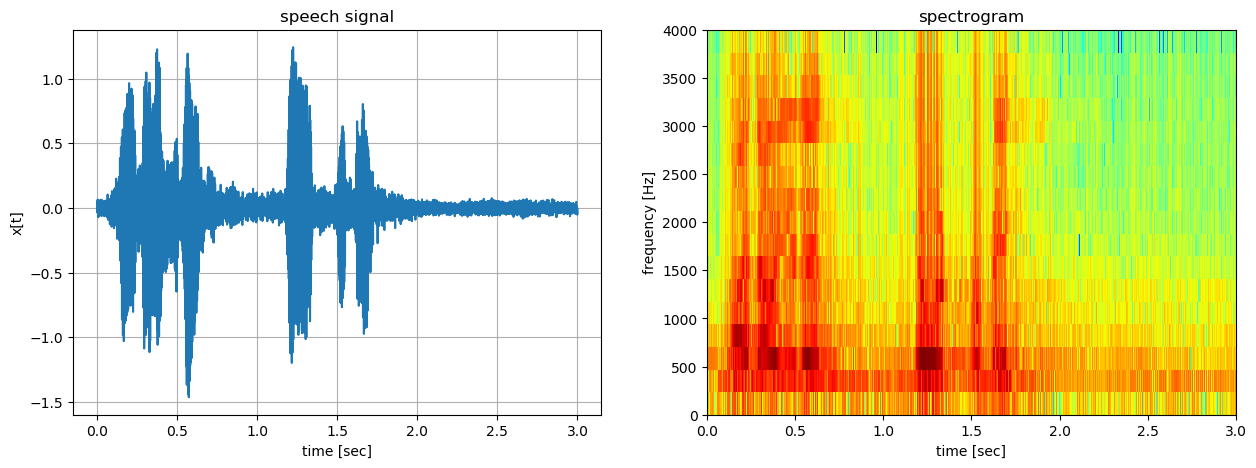

In [4]:
# create figure with subplots
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
ax[1].plot(t, x_time)

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(x_time, 32, 0, fs=fs_desired), fs_desired, ax=ax[2])

# visual modifications
ax[1].grid(), ax[1].set_ylabel("x[t]"), ax[1].set_xlabel("time [sec]"), ax[1].set_title("speech signal"), ax[2].set_title("spectrogram")
;

## Specify generative model

In [5]:
# create factor graph
fg = FactorGraph()

s_min = Array{Variable,1}(undef, 2*length(freq))
w = Array{Variable,1}(undef, 2*length(freq))
s = Array{Variable,1}(undef, 2*length(freq))


# specify observation noise
@RV v ~ GaussianMeanVariance(zeros(buffer_size), σ_observation^2*Ic(buffer_size))


for k = 1:2*length(freq)
    # specify previous hidden state (spectral components)
    @RV [id=pad(:s_min,k)] s_min[k] ~ GaussianMeanVariance(placeholder(pad(:μ_s_min,k)),
                                                           placeholder(pad(:Σ_s_min,k)))
    
    # specify process noise
    @RV [id=pad(:w,k)] w[k] ~ GaussianMeanVariance(0, σ_process^2)
    
    @RV [id=pad(:s,k)] s[k] = s_min[k] + w[k]
end

# specify new hidden state
#@RV svec = sum([s[f]*em(2*length(freq), f) for f = 1:2*length(freq)])
@RV svec
for k = 1:2*length(freq)
    DotProduct(s[k], svec, em(2*length(freq), k))
end

# specify Fourier matrix
@RV C

# specify observations
@RV x = C*svec
@RV y = x + v

# create placeholder for fourier matrix
placeholder(C, :C, dims = (buffer_size, 2*length(freq)))

# create placeholder for observations
placeholder(y, :y, dims = (buffer_size,))

# draw factor graph
ForneyLab.draw(fg)
ForneyLab.draw(fg, external_viewer=:default)
;

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 10553738643181278389 -->
 10553738643181278389 
 
 clamp_88 
 
<!-- 6337177356186561041 -->
 6337177356186561041 
 
 clamp_65 
 
<!-- 12852456807299026348 -->
 12852456807299026348 
 
 dot 
 dotproduct_19 
 
<!-- 5812644244305318301 -->
 5812644244305318301 
 
 clamp_81 
 
<!-- 12852456807299026348--5812644244305318301 -->
 12852456807299026348--5812644244305318301 
 
 clamp_81 
 1 out 
 3 in2 
 
<!-- 16239825982613491250 -->
 16239825982613491250 
 
 + 
 addition_19 
 
<!-- 12852456807299026348--16239825982613491250 -->
 12852456807299026348--16239825982613491250 
 
 s_19 
 1 out 
 1 out 
 
<!-- 7556488434221482163 -->
 7556488434221482163 
 
 dot 
 dotproduct_12 
 
<!-- 18188542159295700057 -->
 18188542159295700057 
 
 clamp_74 
 
<!-- 7556488434221482163--18188542159295700057 -->
 7556488434221482163--18188542159295700057 
 
 clamp_74 
 1 out 
 3 in2 
 
<!-- 3211575857076079496 -->
 3211575857076079496 
 
 + 
 addition_12 
 
<!-- 7556488434221482163--3211575857076079496 -->
 7556488434221482163--3211575857076079496 
 
 s_12 
 1 out 
 1 out 
 
<!-- 736078629938732315 -->
 736078629938732315 
 
 placeholder_Σ_s_min_20 
 
<!-- 2113049470601471857 -->
 2113049470601471857 
 
 = 
 equ_svec_26 
 
<!-- 1534916274943646405 -->
 1534916274943646405 
 
 dot 
 dotproduct_27 
 
<!-- 2113049470601471857--1534916274943646405 -->
 2113049470601471857--1534916274943646405 
 
 svec 
 2 in1 
 1 1 
 
<!-- 9201346710469909485 -->
 9201346710469909485 
 
 = 
 equ_svec_25 
 
<!-- 2113049470601471857--9201346710469909485 -->
 2113049470601471857--9201346710469909485 
 
 svec 
 3 3 
 2 2 
 
<!-- 14325060976979787577 -->
 14325060976979787577 
 
 𝒩 
 gaussianmeanvariance_39 
 
<!-- 10719862285315864210 -->
 10719862285315864210 
 
 clamp_39 
 
<!-- 14325060976979787577--10719862285315864210 -->
 14325060976979787577--10719862285315864210 
 
 clamp_39 
 1 out 
 2 m 
 
<!-- 3957715919935635294 -->
 3957715919935635294 
 
 clamp_40 
 
<!-- 14325060976979787577--3957715919935635294 -->
 14325060976979787577--3957715919935635294 
 
 clamp_40 
 1 out 
 3 v 
 
<!-- 4204740607657822368 -->
 4204740607657822368 
 
 𝒩 
 gaussianmeanvariance_2 
 
<!-- 13672072243904087219 -->
 13672072243904087219 
 
 placeholder_μ_s_min_01 
 
<!-- 4204740607657822368--13672072243904087219 -->
 4204740607657822368--13672072243904087219 
 
 μ_s_min_01 
 1 out 
 2 m 
 
<!-- 12553491366587751344 -->
 12553491366587751344 
 
 placeholder_Σ_s_min_01 
 
<!-- 4204740607657822368--12553491366587751344 -->
 4204740607657822368--12553491366587751344 
 
 Σ_s_min_01 
 1 out 
 3 v 
 
<!-- 13075536910649801920 -->
 13075536910649801920 
 
 clamp_11 
 
<!-- 5131015320479654511 -->
 5131015320479654511 
 
 clamp_24 
 
<!-- 14232687283435969792 -->
 14232687283435969792 
 
 = 
 equ_svec_11 
 
<!-- 14232687283435969792--7556488434221482163 -->
 14232687283435969792--7556488434221482163 
 
 svec 
 2 in1 
 1 1 
 
<!-- 17684288551475793117 -->
 17684288551475793117 
 
 = 
 equ_svec_10 
 
<!-- 14232687283435969792--17684288551475793117 -->
 14232687283435969792--17684288551475793117 
 
 svec 
 3 3 
 2 2 
 
<!-- 10285568427038013105 -->
 10285568427038013105 
 
 𝒩 
 gaussianmeanvariance_22 
 
<!-- 11915654506908914139 -->
 11915654506908914139 
 
 placeholder_Σ_s_min_11 
 
<!-- 10285568427038013105--11915654506908914139 -->
 10285568427038013105--11915654506908914139 
 
 Σ_s_min_11 
 1 out 
 3 v 
 
<!-- 7134750124867336067 -->
 7134750124867336067 
 
 placeholder_μ_s_min_11 
 
<!-- 10285568427038013105--71347

In [6]:
# create algorithm
algo = compatibility_fix(sumProductAlgorithm(vcat(s, x)))

# evaluate algorithm
eval(Meta.parse(algo))
println(algo)
;

begin

function step!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 241))

messages[1] = ruleSPGaussianMeanVarianceOutNPP(nothing, Message(ForneyLab.Univariate, PointMass, m=data[:μ_s_min_01]), Message(ForneyLab.Univariate, PointMass, m=data[:Σ_s_min_01]))
messages[2] = ruleSPGaussianMeanVarianceOutNPP(nothing, Message(ForneyLab.Univariate, PointMass, m=0), Message(ForneyLab.Univariate, PointMass, m=10000.0))
messages[3] = ruleSPAdditionOutNGG(nothing, messages[1], messages[2])
messages[4] = ruleSPGaussianMeanVarianceOutNPP(nothing, Message(ForneyLab.Univariate, PointMass, m=data[:μ_s_min_02]), Message(ForneyLab.Univariate, PointMass, m=data[:Σ_s_min_02]))
messages[5] = ruleSPGaussianMeanVarianceOutNPP(nothing, Message(ForneyLab.Univariate, PointMass, m=0), Message(ForneyLab.Univariate, PointMass, m=10000.0))
messages[6] = ruleSPAdditionOutNGG(nothing, messages[4], messages[5])
messages[7] = ruleSPDotProductIn1GNP(messages[6], nothing, Message(Forn

## Perform inference

In [7]:
messages=Array{Message}(undef, 241)
data = Dict()
marginals = Dict()

# set priors 
μ_s_min = Array{Float64,1}(undef, 2*length(freq))
Σ_s_min = Array{Float64,1}(undef, 2*length(freq))
for k = 1:2*length(freq)
    μ_s_min[k] = randn(1)[1]
    Σ_s_min[k] = 1e2
end

# initialize buffer
buf = BufferData(x_time, t, buffer_size)

# initialize placeholder for hidden states and observation
μ_x = Float64[]
Σ_x = Float64[]

# create progress bar
p = Progress(len(buf, step_size), 1, "Observed ")

# loop through samples
for k = 1:len(buf, step_size)
        
    # update progress bar
    update!(p, k)
    
    # fill data dictionary
    for k = 1:length(freq)*2
        data[pad(:μ_s_min,k)] = μ_s_min[k]
        data[pad(:Σ_s_min,k)] = Σ_s_min[k]
    end
    data[:y] = buf.buffer_s
    data[:C] = calc_C(freq, buf.buffer_t)*sqrt(32)
    
    # infer parameters
    marginals = step!(data, marginals, messages)

    # estimate prediction of x
    push!(μ_x, ForneyLab.unsafeMean(messages[241].dist)[1])
    push!(Σ_x, ForneyLab.unsafeCov(messages[241].dist)[1,1])
    
    # update hidden states
    for k = 1:2*length(freq)
        μ_s_min[k] = ForneyLab.unsafeMean(marginals[pad(:s,k)])
        Σ_s_min[k] = ForneyLab.unsafeCov(marginals[pad(:s,k)]) 
    end
    
    # update buffer
    FLAG_data_remaining = step!(buf, step_size)
    
end

Observed 100%|██████████████████████████████████████████| Time: 0:03:21:48


In [8]:
# convert μ_x to a 1d array
#μ_x_pred = expand(reverse(hcat(μ_x...),dims=1))
μ_x_pred = μ_x
# convert s_x to a 2d array
# if length(size(μ_s)) != 2
#     μ_s = hcat(μ_s...)
# end

# calculate magnitude spectrum
# mag_μ_s = log10.((μ_s[1:length(freq),:].^2 + μ_s[length(freq)+1:end,:].^2))


# create figure with subplots
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
cmp = ax[1].imshow(mag_μ_s,
                   aspect="auto",
                   cmap="jet",
                   origin="lower",
                   extent=[minimum(t), maximum(t), minimum(freq), maximum(freq)])
fig.colorbar(cmp, ax=ax[1])

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(x_time, 32, 0, fs=fs_desired), fs_desired, ax=ax[2], colorbar=true)

# change visuals
ax[1].set_xlim(minimum(t), maximum(t)), ax[1].set_ylim(minimum(freq), maximum(freq)), ax[2].set_ylim(minimum(freq), maximum(freq)), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("frequency [Hz]"), ax[1].set_title("Predicted spectrum"), ax[2].set_title("STFT spectrum")
;

UndefVarError: UndefVarError: mag_μ_s not defined

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQBGmbQ8fipHPduSKj2LnQQ9f8icPAh4ETy2sAu8jBPOvBMsCr3VU/G8OWa0vF/NHbxh1zu79oG+O9VYmTsgK+g7rZBtPBCmejyUuII8bnWHPCwYjTzxfoI8dkDZO3msObw7Aee8Yc4FvaN0Gr3fdf68o+ePvHdxlLsfipA8w+YqPYEabT3DYYQ9fx5xPc3PRj1tBSg9x5wNPV9t3Dx8pMg8cDeZPM+UqDv3YCm8XHSKvFcleLwyCWu8KjkIvDoVFDt8h3Q5IPqhOzkMszzvExU9gI02PVIbIz1vsd48at6nO5hQrbxJySK9IzVavSOLiL0eHpO90gR3vYnNNr2XSMu8Yn+Ju25iRjy/scA8bUaJPJ8u/TsmzL+7IH5vvKUr+rxxzSG9nrMYvdHs3rwFdIS8rFAyvGFTdbxL3y68UcZhutQcZzvA/W48W9CIPK62tjw/ja88Lmx5PDwJcjsN1kq8To4NvalBQr3Jdk698i88vRnh/rxZ1kW8fGvlO5wfyDw9QCI9O0A/PcMNMD118ew8eGsfPDGViLo1YS28CNi8vMJEH73MCVO9eq9tvSJTab0zEEi9J17cvAIvO7xMewA69rYFPMNogTxX5aU8SeKfPHd7lTy377g8btrsPAHc/jxu9sU8vgz4O8BhK7w8ury8lB/JvG2AsLwCwpO8B8cevK2GaDulRqI8rswfPfpgST1iYUU97UkdPYjrpzxbVoC7v3vSvBj9IL0Xyj69PQRTvT9OXr14u2u9WDFsvXdCWb3kLjK9tHfevOsYiLxDcdK7GZeDu0DmJDt1j7Q7CZBjO+QxAbvjvA+87tbJvF3M9ry8cw+9fzUQvUmIpbx0V9g72PkUPfHAWT1Hnno94Y1vPZsCOz3NbwY9tna2PEnbBjwkeCq8/o8CvazBOb3+pDm9zJAavebK7LwoKI28IA0tvI7aIbz42pi7JIDNO9HsizwQzbc8oaPGPGGd3jy4Y8k8znoYPPs/aLyPoRe94EtIvVR8Zr2QlGC9vYMSvaSVG7zGZYM87SkOPY5ePj1ozW49F5CBPY8SWD1aTjM92Lr9PKGnjjzt7l08XYlRPJ5tYTySjj08VXGiO79unLoZ2p66JWybO4/XgDywTak8wbSvPGMyyDyI0Oo8kwQdPbeXOD3+7xY9LfAbPPCQi7xjT/q8niUuvfdaV70jA3q9DOdcvV3BNb1GlNi89YbWu4wWXDxV7bk8/z+OPEyWOzyeRIQ75fzIu/AanLwu9xG9lYo7vXPeRL3/+Cm9p1PWvIqzC7wXHo47xDU7PNfkHDwYl+I7wdT0Oyvg3jsVuFY7b/XTukhW/rsod7e8ajQhvZqKUL2iImu9FvRtvW/hUL1arRi9p7iCvCx2wDtkILw8Okw8PUEHdD0pM109zeMMPc7vZDy5fEg706iVu2QbWLxvdKW8aoa1vF7Zwrwf4Oy8w60BvRP2z7z1s268yUOxux8/DTzcn4Y8bsevPB960DxuUNo8tHzyPNoV4TxbKnM89nsGPIQvxztC94G7WQ7zu+iO47t8JAy7aeAnPMxhsTx85wo9wQAlPfFWGz2/qR09t8kaPb3P/Dxj8ZQ82OE1u+sTkbxTLce8GWb3vLovBb1otSO9TI81vTANN71kWi69WDgNvRgs87yZ5sS85B1cvItUO7sva4o7Ss2VuTOvg7z0NQa9utlDvZ3hbb0zPWq9Dd9Bvb/IBL0hJn+8vaO0O/yhwjxdsio9vA0+PZ8lJD1uwNI8JZ0hPJsY/DqulDq8jurzvJU4Fb0iJwW9gWnwvJALtrypkJC8+3gJvHkamDiv17U7O4QhPEAxkjyqqcI8nYDZPJHB2DxQHdE8EfWjPKTlCzxtODK82vQLvZQ7Ur24H3G9M/tlvZqvM70qHNq8ae8HvFhNKTwDMgA956QiPTjrDD0oW7E8V3IIPEwBtbqWCA28B7MvvNUXs7vK0n06uayUOh9TSzs/pvg6U1YCu/J3gjq/Akc7/EQRPD9uTTy9S8Y8CHQePVjuVj2twl49ejcUPZlPNTyg9XS8Bn4cvW/NXr3xkoK9kYtqvQIHJL3lgq+8ILZaudWXnjzrFP08XcEEPYBU4DwSrpg8jwnuO9/SpLvXW0W8bT2CvLPoTLyRrES8zeEqvAp7mLqMVo87jnROPCWFqzypuKs8JQiTPNFlsjzDP708nLelPEwSkTwiUg08bny3u3TWmLxNIe28I/gLvfIZG70zNRi9Nm3ZvKwOlruxTtA8oOg+PXcCZD3arUo9gCsAPa9roDw5zoM8IMRIPOFPYjsKHse7sGlsvP5doLyaBqW8WIKMvFP/k7yW5ai8g4SCvKvAGrw1qQw6qy9vPLmP4Dz3zBI9z8oYPfNa4DxoyYY8EbAKu/8DiLwzb+W8NTodvZDmJL1Yqiy9rR4Mve19obwK+du7WHcQPN4ciTwAEXc8/eFnPNchIjw5s6Q7OjMGu28KWLyTrOG8XSsPvcRiKL0b6SW97pYgvQLsI7070RC9fTYGvb4Lx7z9W1a8QDzju5MRRjp3eSI7eg7BuUEB+Lu6aLS8+VMAvTeqPr39SXO9OGGAvY0YV72Ry+C8B+uiORCmqzwgSQU92dENPZ8qDj1M5+Q8DMSIPE1NpDqWiD28unWQvN1Ocbwalsq6jvkrOx48QzuuZ2474inKOkLc5zs+Cyo8ImYGPHdn+js10+I62oAXO1g5LTtQ2Zw6mUHpu3SsobxNJwW9bstIvYwMdL0HiZC9avOUvU6Gj71MamS9SJ4BvTS/lbsaHaU8qczzPJfxCj2XajA9RrNoPW1rkD0f4aE9qPe2Pfzivz1yOsk91EvTPWpbyT3VH7M9L36SPfh6aD3GQys9eeTcPB9+KTw7rOc6Bt76uvOsmruMQxC8hqatvD6+LL3/X2u94TOLvfvunr2P+qu9tqG2vdvyrL1PWJC9cgRHvZ+r9Lx0oYa8Iz7yu+N3qbjfdqs7ba8nPFDojjzIH7A8XqnfPBPA+TyRdwI9ZUsGPTbeET3y+iE9AqkkPdibEj2+Mtc8y+6dPBHHUjy1VoI550Y/vB+Gu7yySSe9ONJ3veYOoL37Gru9AhW9vfqMt70zmKO9xjtrvZn23Ly2bLc7yIX9PB6WQD0gCnc9EUOEPWTkfD0KZGQ9zqRHPaPIIz1mPw096pEePT+RFD3R3PI8+j3CPCU1gjwx0mE81UEZPMlhQrtRbHu8a5LgvNB4Br3zDRm99v8HvfVfCL0NMhq96HQhvVA4J72bmyS9FQsmveCsFL2U76+8W7MPO+gH/TwwAFk9DgyHPXYSjj1oE4c94hFdPbGWQj243Uo9NLpEPVAGNT1m9Aw9hl/YPOgLoDweeF48c6T3Ooogm7wmNgi9WF09vUL3aL2zy4K9lF2avQfdoL2+A569k/CgvQUes7077NG9eMntvaEuAb5Lcv298UvrveALyL0b0Za9VTovvWV5H7wC+lk8BfPWPOaDCD0DWAk9U0AFPTxT8zxiwb48s16WPPYNWDyWSVU8aCWbPOSz1Tz8/d08rKPqPPEfBj3Nng89CNv2PN8JnTw1mgg8QHgaO5uyyzqtDHU7T12oO15AoTn4eIO7VAwovNQNqLzI9+283ij4vE4Nq7zoBNm7WUPkO7jlqzwYGvc8eXAVPQ06DD1+gck8bS9nPMPmQzw3LHE8v7NdPD32Bjz/G+U6W/oAvEITcLxm+bC8ppq8vPfr5rx3gwa9O5DyvOuuzbwMoLC8BaJGvPgLQruumDk8d7/1PBO9Mz3Tolo9WY5ePVfiVz1C9Gk9qwiCPZTQmj3DP7k9T+bFPWmXxj1Xq7g9VMqfPUUmfj23azQ9L4vHPEkIQDsknM+8QGJDvZmjkr2zZci9L2n8vWseDb6/m

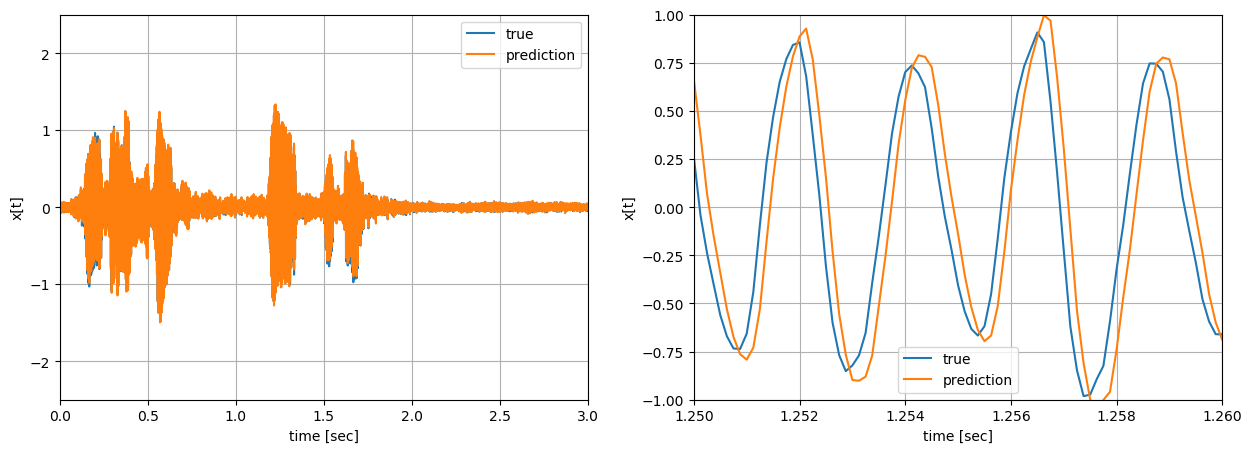

In [9]:
# create figure with subplots
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot actual, noisy and marginal of frequency component
ax[1].plot(t, x_time, label="true"), ax[1].plot(t[1:length(μ_x_pred)], μ_x_pred, label="prediction")
ax[2].plot(t, x_time, label="true"), ax[2].plot(t[1:length(μ_x_pred)], μ_x_pred, label="prediction")

# change vizualization
ax[1].grid(), ax[1].set_xlim(0,3), ax[1].set_ylim(-2.5, 2.5), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("x[t]"), ax[1].legend()
ax[2].grid(), ax[2].set_xlim(1.25,1.26), ax[2].set_ylim(-1, 1), ax[2].set_xlabel("time [sec]"), ax[2].set_ylabel("x[t]"), ax[2].legend()

# create audioplayers
audioplayers(x_time, μ_x_pred, fs=fs_desired)
;

## Performance metrics

In [10]:
MSE = 1/length(μ_x_pred) * sum(abs.(μ_x_pred - x_time[1:length(μ_x_pred)]).^2)

0.016650210866117995

In [11]:
MAE = 1/length(μ_x_pred) * sum(abs.(μ_x_pred - x_time[1:length(μ_x_pred)]))

0.061924666320552074

In [12]:
using Distributions;
logBME = Float64[]
# initialize buffer
buf = BufferData(x_time, t, buffer_size)
for k = 1:length(μ_x)
    try 
        push!(logBME, logpdf(Distributions.Normal(μ_x[k][1], Σ_x[k][1,1]), buf.buffer_s[1]))
    catch
    end
    step!(buf, step_size)
end
print("nr: "* string(length(logBME))* "       mean:"* string(mean(logBME)))

nr: 23968       mean:-16.3030651242529